<a href="https://colab.research.google.com/github/M-Abbi/Financial-Modeling/blob/main/GLMs_with_practical_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Small Project: Loan Default Prediction using Generalized Linear Models (Logistic Regression)

## 1. Introduction to Generalized Linear Models (GLMs)

Generalized Linear Models (GLMs) are a flexible generalization of ordinary linear regression. They allow for response variables that have error distribution models other than a normal distribution.
A GLM consists of three components:
1.  **Random Component:** Identifies the probability distribution of the response variable (Y). Examples include Normal, Bernoulli, Poisson, Gamma.
2.  **Systematic Component (Linear Predictor):** Specifies the explanatory variables (X₁, X₂, ..., Xₚ) used in a linear predictor function: η = β₀ + β₁X₁ + ... + βₚXₚ.
3.  **Link Function (g):** Specifies the link between the random component (the expected value of Y, μ = E[Y]) and the systematic component (the linear predictor η). So, g(μ) = η.

## 2. Logistic Regression: A Specific GLM for Binary Outcomes

Logistic Regression is a GLM used when the response variable (Y) is binary (e.g., 0 or 1, Yes or No, Default or No Default).

*   **Random Component:** Bernoulli distribution. The outcome Y can be 0 or 1. E[Y] = p, where p is the probability of Y=1.
*   **Link Function:** Logit link. g(p) = ln(p / (1-p)). This is the natural logarithm of the odds.
*   **Systematic Component:** η = β₀ + β₁X₁ + ... + βₚXₚ.

So, for Logistic Regression:
ln(p / (1-p)) = β₀ + β₁X₁ + ... + βₚXₚ

This means the model predicts the log-odds of the event occurring. We can then convert this back to a probability:
p = 1 / (1 + exp(-η))

## 3. Simple Financial Example Application: Predicting Loan Default

**Problem:** A financial institution wants to predict the likelihood of a borrower defaulting on a loan based on certain characteristics.

**Objective:** Build a Logistic Regression model to estimate the probability of default.

**Features (Simplified & Synthetic):**
*   `credit_score`: A numerical score representing creditworthiness (e.g., 300-850). Higher is better - FICO score taken for inspiration.
*   `loan_to_income_ratio`: The ratio of the loan amount to the borrower's annual income. Higher might indicate more risk.
*   `employment_duration_years`: Number of years the borrower has been at their current job. Longer might indicate stability.

**Target Variable:**
*   `default_status`: Binary (1 if defaulted, 0 if not defaulted).

## 4. Model Implementation Steps

1.  **Data Preparation:**
    *   Load/Generate data.
    *   Handle missing values (if any, though we'll use synthetic data).
    *   Encode categorical variables (if any).
    *   Split data into training and testing sets.
    *   Feature Scaling (e.g., StandardScaler) can be beneficial for Logistic Regression, especially if regularization is used or features are on very different scales.
2.  **Model Training:**
    *   Instantiate a Logistic Regression model.
    *   Train the model using the training data (X_train, y_train).
3.  **Model Evaluation:**
    *   Make predictions on the test set (X_test).
    *   Evaluate performance using metrics like:
        *   Accuracy
        *   Precision, Recall, F1-score (especially for imbalanced datasets)
        *   Confusion Matrix
        *   ROC Curve and AUC (Area Under the Curve)
4.  **Coefficient Interpretation:**
    *   Examine the model coefficients (β values).
    *   The sign of a coefficient indicates the direction of the relationship (positive or negative) between the feature and the log-odds of default.
    *   The magnitude, when exponentiated (exp(β)), gives the odds ratio. For a one-unit increase in Xᵢ, the odds of default are multiplied by exp(βᵢ), holding other variables constant.

## 5. Assumptions of Logistic Regression

*   **Binary Outcome:** The dependent variable must be binary.
*   **Independence of Observations:** Observations should be independent of each other.
*   **Linearity of Logit:** The relationship between the logit of the outcome and each continuous independent variable is linear.
*   **No Severe Multicollinearity:** Independent variables should not be too highly correlated with each other.
*   **Large Sample Size:** Logistic regression typically requires a larger sample size than OLS regression for stable estimates.

---

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

1.  **Data Preparation - General Steps:**
    *   Load/Generate data.
    *   Handle missing values (if any, though we'll use synthetic data).
    *   Encode categorical variables (if any).
    *   Split data into training and testing sets.
    *   Feature Scaling (e.g., StandardScaler) can be beneficial for Logistic Regression, especially if regularization is used or features are on very different scales.
    * I ALWAYS want to plot the data to check them visually.

In [3]:
# --- 1. Data Generation (Synthetic Financial Data for Loan Default) ---
np.random.seed(42) # for reproducibility
num_samples = 1000

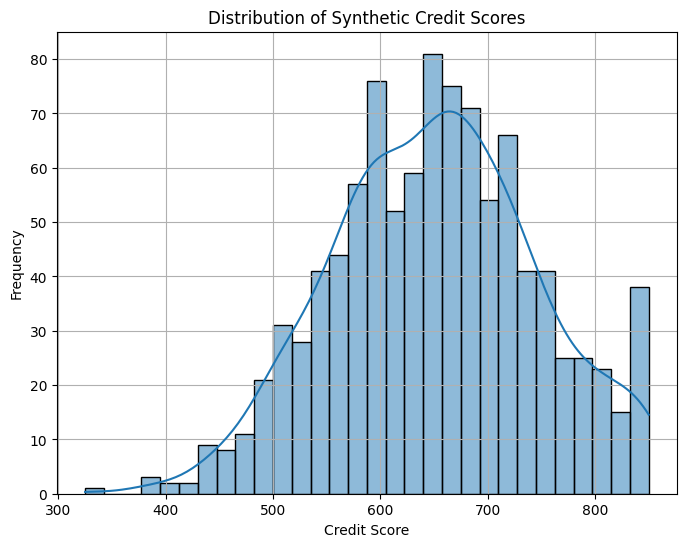

In [4]:
# Feature 1: Credit Score (higher is better, less likely to default)
# Let's assume scores are somewhat normally distributed, centered around 650
credit_score = np.random.normal(loc=650, scale=100, size=num_samples).astype(int)
credit_score = np.clip(credit_score, 300, 850) # Clip to a realistic range

# Plotting the Credit Score distribution
plt.figure(figsize=(8, 6))
sns.histplot(credit_score, bins=30, kde=True)
plt.title('Distribution of Synthetic Credit Scores')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

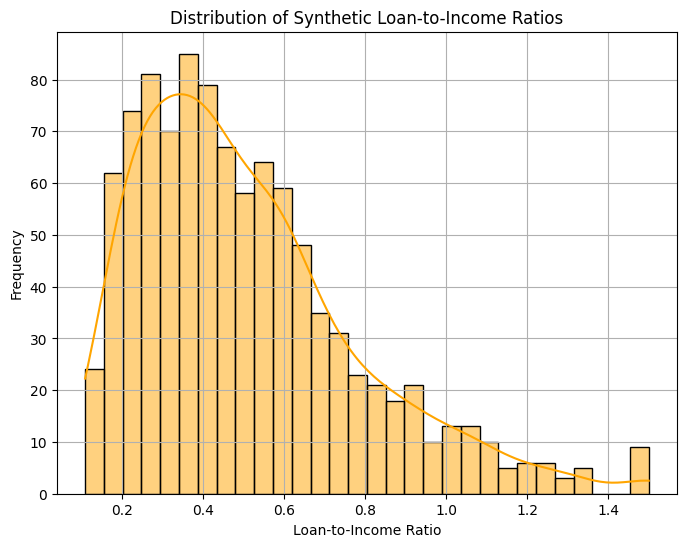

In [5]:
# Feature 2: Loan-to-Income Ratio (LTI) (higher ratio, more likely to default)
# Let's assume LTI is somewhat log-normally distributed or gamma-like
lti_ratio = np.random.gamma(shape=2, scale=0.2, size=num_samples) + 0.1 # Avoid zero
lti_ratio = np.clip(lti_ratio, 0.1, 1.5) # Realistic range, 10% to 150%

# Plotting the LTI Ratio distribution
plt.figure(figsize=(8, 6))
sns.histplot(lti_ratio, bins=30, kde=True, color='orange')
plt.title('Distribution of Synthetic Loan-to-Income Ratios')
plt.xlabel('Loan-to-Income Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

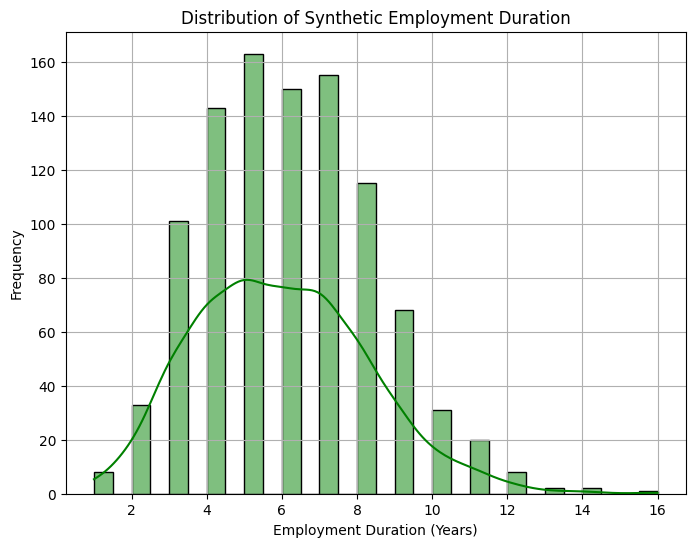

In [7]:
# Feature 3: Employment Duration (years) (longer duration, less likely to default)
employment_duration = np.random.poisson(lam=5, size=num_samples) + 1 # Min 1 year
employment_duration = np.clip(employment_duration, 1, 30)

# Plotting the Employment Duration distribution
plt.figure(figsize=(8, 6))
sns.histplot(employment_duration, bins=30, kde=True, color='green')
plt.title('Distribution of Synthetic Employment Duration')
plt.xlabel('Employment Duration (Years)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

2.  **Model Training:**
    *   Instantiate a Logistic Regression model.
    *   Train the model using the training data (X_train, y_train).
    

In [8]:
# Create the target variable 'default_status' based on a logistic function
# We'll define a log-odds function based on our features
# log_odds = intercept + B1*credit_score + B2*lti_ratio + B3*employment_duration
# We want:
# - Higher credit score -> lower log_odds (negative B1)
# - Higher LTI ratio -> higher log_odds (positive B2)
# - Higher employment duration -> lower log_odds (negative B3)

# Arbitrary coefficients for generating data (these are NOT the model's learned coefficients)
intercept_true = -2.0
beta_credit_score_true = -0.01
beta_lti_true = 2.5
beta_employment_true = -0.15

log_odds = (intercept_true +
            beta_credit_score_true * ((credit_score - np.mean(credit_score)) / np.std(credit_score)) + # Standardize for generation
            beta_lti_true * ((lti_ratio - np.mean(lti_ratio)) / np.std(lti_ratio)) +
            beta_employment_true * ((employment_duration - np.mean(employment_duration)) / np.std(employment_duration)))

# Convert log-odds to probability
probabilities = 1 / (1 + np.exp(-log_odds))

# Generate binary default status based on these probabilities
default_status = np.random.binomial(1, probabilities)

# Create DataFrame
df = pd.DataFrame({
    'credit_score': credit_score,
    'lti_ratio': lti_ratio,
    'employment_duration_years': employment_duration,
    'default_status': default_status
})

print("--- Synthetic Data Head ---")
print(df.head())
print("\n--- Default Status Distribution ---")
print(df['default_status'].value_counts(normalize=True))

--- Synthetic Data Head ---
   credit_score  lti_ratio  employment_duration_years  default_status
0           699   0.940914                          6               1
1           636   0.733605                          5               1
2           714   0.448968                          8               0
3           802   0.292643                          5               0
4           626   0.722012                          3               0

--- Default Status Distribution ---
default_status
0    0.764
1    0.236
Name: proportion, dtype: float64


In [10]:
# --- 2. Data Preparation ---
X = df[['credit_score', 'lti_ratio', 'employment_duration_years']]
y = df['default_status']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames for easier coefficient interpretation later
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [12]:
# --- 3. Model Training (Logistic Regression) ---
# For GLM understanding, we use LogisticRegression from sklearn
# C is the inverse of regularization strength; smaller C means stronger regularization.
# penalty='l2' is common (Ridge). 'none' can be used if no regularization is desired.
# solver='liblinear' is good for smaller datasets and supports L1/L2. 'lbfgs' is often default.
model = LogisticRegression(solver='liblinear', random_state=42, C=1.0, penalty='l2')
model.fit(X_train_scaled_df, y_train)

print("\n--- Model Trained ---")


--- Model Trained ---


In [13]:
# --- 4. Model Evaluation ---
y_pred_test = model.predict(X_test_scaled_df)
y_pred_proba_test = model.predict_proba(X_test_scaled_df)[:, 1] # Probabilities for the positive class (default=1)

print("\n--- Model Evaluation on Test Set ---")


--- Model Evaluation on Test Set ---


In [14]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8640



Confusion Matrix:
[[178  13]
 [ 21  38]]


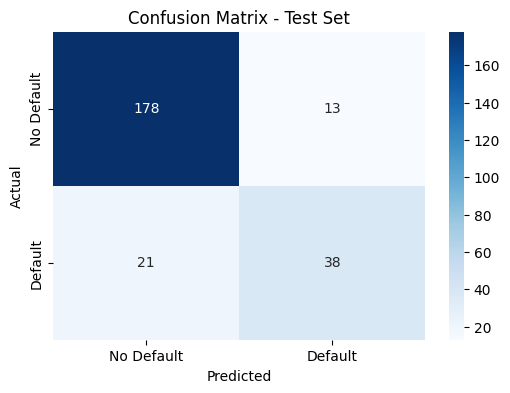

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()

In [16]:
# Classification Report (Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=['No Default (0)', 'Default (1)']))


Classification Report:
                precision    recall  f1-score   support

No Default (0)       0.89      0.93      0.91       191
   Default (1)       0.75      0.64      0.69        59

      accuracy                           0.86       250
     macro avg       0.82      0.79      0.80       250
  weighted avg       0.86      0.86      0.86       250



In [17]:
# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba_test)
print(f"\nROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.9184


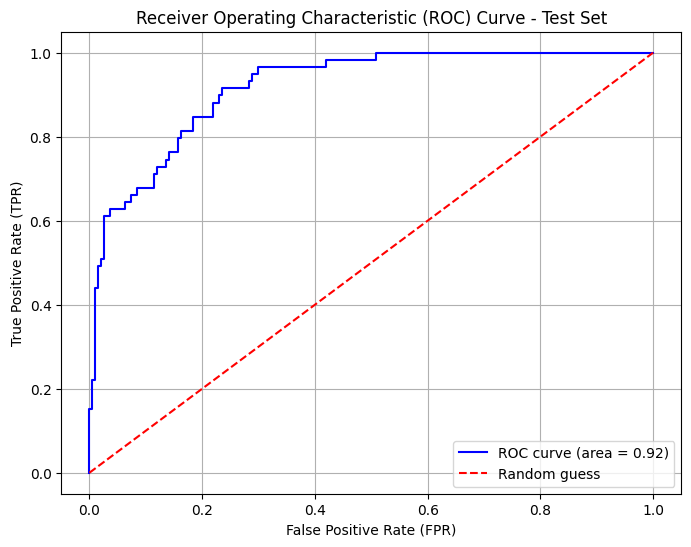

In [18]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# --- 5. Coefficient Interpretation ---
print("\n--- Model Coefficients ---")
print(f"Intercept (β₀): {model.intercept_[0]:.4f}")

coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient (β)': model.coef_[0]
})
coefficients['Odds_Ratio (exp(β))'] = np.exp(coefficients['Coefficient (β)'])
print(coefficients)

print("\nInterpreting Coefficients (for scaled features):")
print("- Intercept: The log-odds of default when all scaled features are zero (i.e., at their mean values).")
for index, row in coefficients.iterrows():
    feature_name = row['Feature']
    coeff_val = row['Coefficient (β)']
    odds_ratio = row['Odds_Ratio (exp(β))']

    interpretation = ""
    if coeff_val > 0:
        interpretation = f"a one-unit increase in the scaled '{feature_name}' is associated with an increase in the log-odds of default by {coeff_val:.4f}. The odds of default are multiplied by {odds_ratio:.4f}."
    else:
        interpretation = f"a one-unit increase in the scaled '{feature_name}' is associated with a decrease in the log-odds of default by {abs(coeff_val):.4f}. The odds of default are multiplied by {odds_ratio:.4f} (i.e., divided by {1/odds_ratio:.4f})."
    print(f"- {feature_name}: {interpretation}")

print("\nNote: Coefficients are for *scaled* features. A one-unit increase in a scaled feature corresponds to a one standard deviation increase in the original feature's value from its mean.")


--- Model Coefficients ---
Intercept (β₀): -1.9750
                     Feature  Coefficient (β)  Odds_Ratio (exp(β))
0               credit_score         0.000374             1.000374
1                  lti_ratio         2.657353            14.258499
2  employment_duration_years        -0.193933             0.823713

Interpreting Coefficients (for scaled features):
- Intercept: The log-odds of default when all scaled features are zero (i.e., at their mean values).
- credit_score: a one-unit increase in the scaled 'credit_score' is associated with an increase in the log-odds of default by 0.0004. The odds of default are multiplied by 1.0004.
- lti_ratio: a one-unit increase in the scaled 'lti_ratio' is associated with an increase in the log-odds of default by 2.6574. The odds of default are multiplied by 14.2585.
- employment_duration_years: a one-unit increase in the scaled 'employment_duration_years' is associated with a decrease in the log-odds of default by 0.1939. The odds of def

In [22]:
# --- (Optional) Further Analysis: Statsmodels for more detailed GLM summary ---
import statsmodels.api as sm

# Add constant for intercept term for statsmodels
X_train_scaled_sm = sm.add_constant(X_train_scaled_df, has_constant='add') # 'has_constant' can be explicit

# Fit GLM (Logistic Regression) using statsmodels
# family=sm.families.Binomial() specifies the Bernoulli distribution and logit link
glm_model = sm.GLM(y_train, X_train_scaled_sm, family=sm.families.Binomial())
glm_results = glm_model.fit()

print("\n\n--- Statsmodels GLM Summary ---")
print(glm_results.summary())
print("\nThis summary provides p-values for coefficients, confidence intervals, and other useful statistics.")



--- Statsmodels GLM Summary ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:         default_status   No. Observations:                  750
Model:                            GLM   Df Residuals:                      746
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -196.75
Date:                Thu, 15 May 2025   Deviance:                       393.51
Time:                        17:04:18   Pearson chi2:                     872.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4334
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------